## Download Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d snap/amazon-fine-food-reviews

 94% 228M/242M [00:01<00:00, 149MB/s]
100% 242M/242M [00:01<00:00, 129MB/s]


In [ ]:
! unzip amazon-fine-food-reviews.zip

Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

## Importing Libraries

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from wordcloud import ImageColorGenerator

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

In [ ]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
df = pd.read_sql_query("SELECT * FROM Reviews", con) 
print("Number of data points in our data", df.shape)
df.head()

Number of data points in our data (568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## Missing Values

In [ ]:
# Checking for any Missing values.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568454 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568454 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


We can notice that we do not have any missing values in our DataFrame.

## Data Cleaning: Deduplication

It is observed that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. 

In [ ]:
# Check for duplicate entries.

dup = df[df.duplicated(subset=['UserId','ProfileName','Time','Text'],keep=False)]
dup.shape

(232415, 10)

In [ ]:
# Example for duplicate entries.

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text .Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

In [ ]:
# Sorting data according to ProductId in ascending order
sorted_data = df.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# Deduplication of entries
df = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False, ignore_index=True)
df.shape

(393933, 10)

In [ ]:
#Checking to see how much % of data still remains

print('Remaining data is %r' %((df['Id'].size*1.0)/(sorted_data['Id'].size*1.0)*100))

Remaining data is 69.29901100176971


Our data point got reduced to approximately 69%.

## Analysis of Reviews over Time

In [ ]:
df['Date'] = pd.to_datetime(df['Time'], unit='s')
df1 = df[['Date', 'Text', 'Score']]
df1.Date = df.Date.dt.strftime('%Y-%m')
df1 = df1.sort_values('Date', ignore_index = True)

In [ ]:
df_1 = df1[df1['Score'] == 1]
df_2 = df1[df1['Score'] == 2]
df_3 = df1[df1['Score'] == 3]
df_4 = df1[df1['Score'] == 4]
df_5 = df1[df1['Score'] == 5]

In [ ]:
df_1 = df_1.groupby('Date')['Score'].count().reset_index()
df_2 = df_2.groupby('Date')['Score'].count().reset_index()
df_3 = df_3.groupby('Date')['Score'].count().reset_index()
df_4 = df_4.groupby('Date')['Score'].count().reset_index()
df_5 = df_5.groupby('Date')['Score'].count().reset_index()

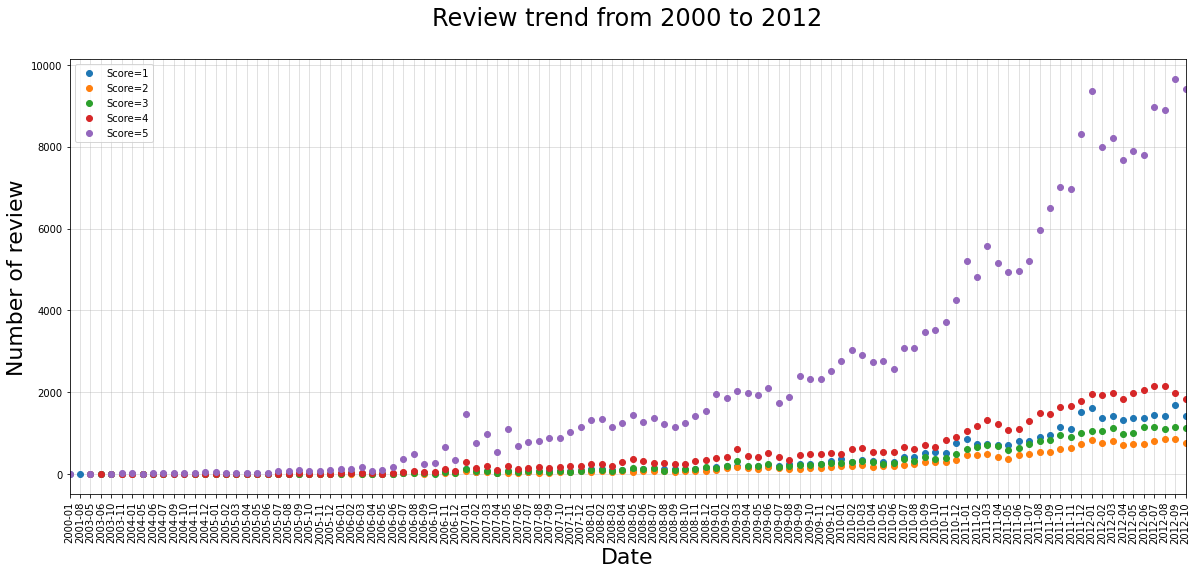

In [ ]:
plt.figure(figsize=(20,8))
plt.plot_date(df_1.Date, df_1.Score, label = 'Score=1')
plt.plot_date(df_2.Date, df_2.Score, label = 'Score=2')
plt.plot_date(df_3.Date, df_3.Score, label = 'Score=3')
plt.plot_date(df_4.Date, df_4.Score, label = 'Score=4')
plt.plot_date(df_5.Date, df_5.Score, label = 'Score=5')
plt.grid(linewidth=0.5, alpha=0.75)
plt.xticks(rotation = 90)
plt.xlim('2000-01', '2012-10')
plt.xlabel('Date', fontsize=22)
plt.ylabel('Number of review',fontsize=22)
plt.title('Review trend from 2000 to 2012\n',fontsize=24);
plt.legend()
plt.show()

**Observation:**
* The total number of reviews has been increasing with time

* The number of reviews having rating 5 has been significantly increasing compared to other rating scores.

## Analysis on Score (Target variable)

1-Star Reviews constitute 9.22% of all reviews.
2-Star Reviews constitute 5.28% of all reviews.
3-Star Reviews constitute 7.56% of all reviews.
4-Star Reviews constitute 14.24% of all reviews.
5-Star Reviews constitute 63.71% of all reviews.



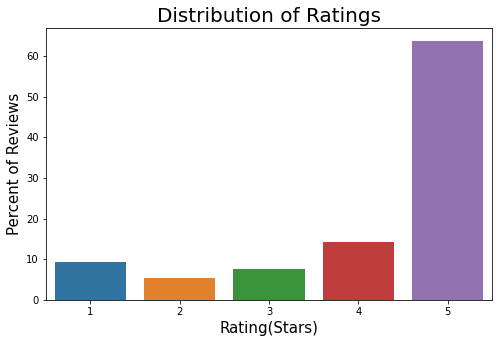

In [ ]:
ratings, counts = np.unique(df['Score'], return_counts=True)
for rating, count in zip(ratings, counts):
    print('{}-Star Reviews constitute {}% of all reviews.'.format(rating,round(count*100/len(df),2)))
print()

plt.figure(figsize=(8,5))
sns.barplot(x='Score', y='Score', data=df, estimator=lambda x: len(x)/len(df)*100)
plt.xlabel('Rating(Stars)', fontsize=15)
plt.ylabel('Percent of Reviews', fontsize=15)
plt.title('Distribution of Ratings', fontsize=20)
plt.show()

In [ ]:
# Score = 1 or 2 => Negative Review
# Score = 4 or 5 => Positive Review

df1 = df[df['Score'] != 3] 
print('Number of data points =', df1.shape[0])
#Checking to see how much % of data still remains
print(f'Remaining data is {((df1.shape[0]*1.0)/(df.shape[0]*1.0))*100}')

Number of data points = 364161
Remaining data is 92.44236964153802


In [ ]:
df1['Score'] = df1['Score'].map(lambda x: 1 if x > 3 else 0)
df1.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Date
0,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,1,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...,2005-02-15
1,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,2007-10-04
2,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",2007-11-11


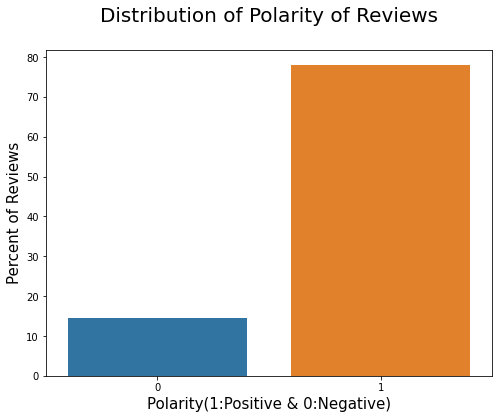

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x='Score', y='Score', data=df1, estimator=lambda x: len(x)/len(df)*100)
plt.xlabel('Polarity(1:Positive & 0:Negative)', fontsize=15)
plt.ylabel('Percent of Reviews', fontsize=15)
plt.title('Distribution of Polarity of Reviews\n', fontsize=20)
plt.show()

**Observation:**
It is an Imbalanced dataset.So we cannot choose accuracy as a metric. So here we will go with AUC(Area under ROC curve).

> Why accuracy is not useful for imbalanced datasets?

Consider a scenario like this where we have imbalenced dataset. For example consider case of credit card fraud detection with 98% percentage of points as non-fraud(0) and rest 2% points as fraud(1). In such cases even if we predict all the points as non-fraud also we will get 98% accuracy. But actually it is not the case. So we can't use accuracy as a metric.

> What is AUC ROC?

AUC is the area under ROC curve.It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting positive(1) as positve(1) and negative(0) as negative(0). The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.

## Analysis of Helpfulness

It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
df[df['HelpfulnessNumerator'] > df['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Date
110854,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...,2008-10-25
200962,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...,2008-06-08


In [ ]:
df = df[df['HelpfulnessNumerator'] <= df['HelpfulnessDenominator']]
df.shape

(393931, 10)

## Analysis of Popular words in reviews

In [ ]:
positive_reviews = df[df.Score > 3]
negative_reviews = df[df.Score < 3]

In [ ]:
positive_reviews_text = " ".join(positive_reviews.Text.to_numpy().tolist() + positive_reviews.Summary.to_numpy().tolist())
negative_reviews_text = " ".join(negative_reviews.Text.to_numpy().tolist() + negative_reviews.Summary.to_numpy().tolist())

positive_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="black").generate(positive_reviews_text)
negative_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="black").generate(negative_reviews_text)

In [ ]:
def show_word_cloud(cloud, title):
    plt.figure(figsize = (15, 8))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show();

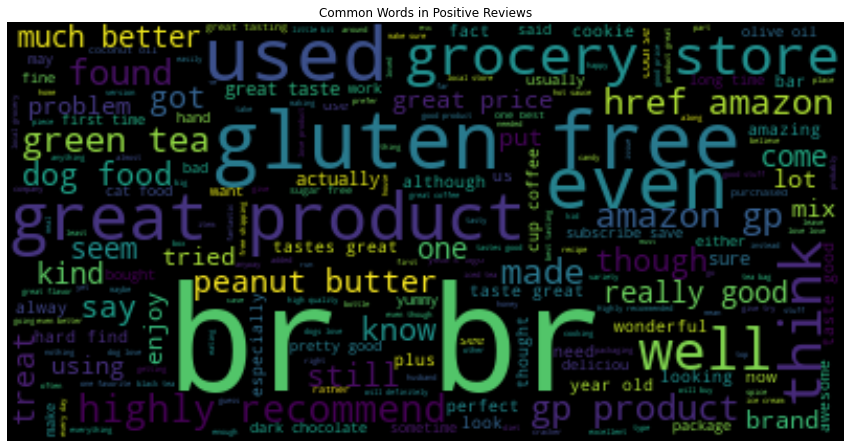

In [ ]:
show_word_cloud(positive_reviews_cloud, "Common Words in Positive Reviews")

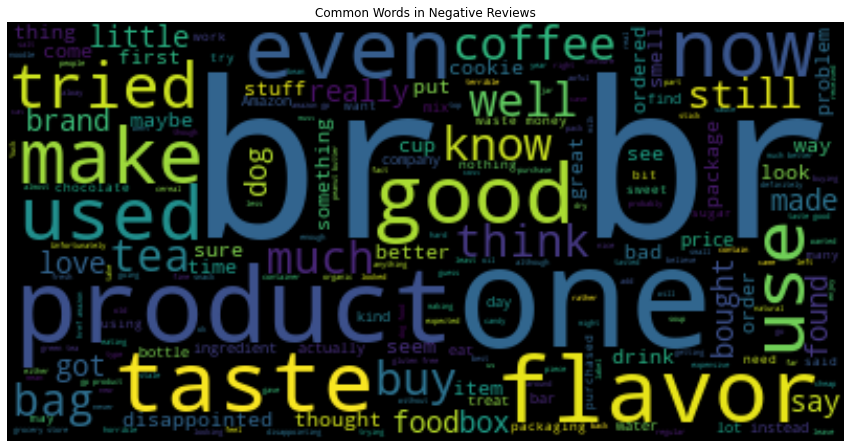

In [ ]:
show_word_cloud(negative_reviews_cloud, "Common Words in Negative Reviews")

## Analysis of Word Count

In [ ]:
data = pd.DataFrame({'Score':df['Score'], 'Count':df['Text'].str.count(' ')+1})
data = data.sort_values('Count')[:380000]
data.describe()

,Score,Count
count,380000.000000,380000.000000
mean,4.185797,71.058839
std,1.311984,48.938314
min,1.000000,3.000000
25%,4.000000,34.000000
50%,5.000000,56.000000
75%,5.000000,93.000000
max,5.000000,250.000000


###How does word count vary by rating?

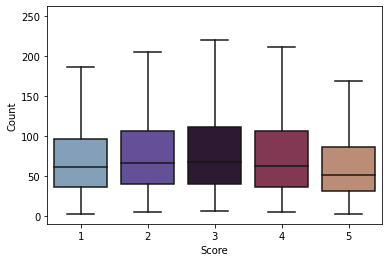

In [ ]:
sns.boxplot(x='Score', y='Count' , data=data, palette='twilight', fliersize=0.0)

**Observation:** 5-star reviews had the lowest median word count (53 words), while 3-star reviews had the largest median word count (71 words).

## Analysis of Frequency of reviewers

In [ ]:
data = df['UserId'].value_counts().rename_axis('unique_values').reset_index(name='counts')
df2 = data[data['counts'] >= 50]
print((df2.shape[0]/data.shape[0])*100)

0.044911524297134645


In [ ]:
data

,unique_values,counts
0,AY12DBB0U420B,329
1,A3OXHLG6DIBRW8,278
2,A281NPSIMI1C2R,259
3,A1YUL9PCJR3JTY,214
4,A1Z54EM24Y40LL,211
...,...,...
256054,AK2PEM3N8A78H,1
256055,A3VRRKE6UJ6OO,1
256056,A3KJZTSALOMMB3,1
256057,AY28IKMOH8AF9,1


Using User IDs, one can recognize repeat reviewers. Reviewers that have reviewed over 50 products account for approx 5% of all reviews in the database. We will call such reviewers frequent reviewers. (The cutoff choice of 50, as opposed to another choice, seemed to not have a larger impact on the results.)

###Are frequent reviewers more discerning?

In [ ]:
data = df[['UserId', 'Score', 'Text']]
data['Count'] = data.Text.str.count(' ')+1
data['freq'] = np.where(data['Count'] >= 50, 'Frequent Reviewer', 'Not a frequent reviewer')
data.drop(['Text','Count'], axis=1, inplace=True)
data.head(3)

,UserId,Score,freq
0,A25ACLV5KPB4W,4,Frequent Reviewer
1,A1S4A3IQ2MU7V4,4,Not a frequent reviewer
2,A2IW4PEEKO2R0U,4,Not a frequent reviewer


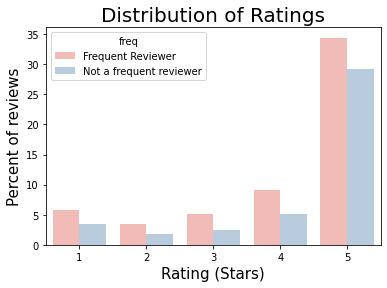

In [ ]:
sns.barplot(x='Score', y='Score', hue='freq', data=data , estimator=lambda x: len(x)/len(df)*100, palette='Pastel1')
plt.xlabel('Rating (Stars)', fontsize=15)
plt.ylabel('Percent of reviews', fontsize=15)
plt.title('Distribution of Ratings', fontsize=20)
plt.show()

**Observation:**
* The distribution of ratings among frequent reviewers is similar to that of all reviews. However, we can see that frequent reviewers give less 5-star reviews and less 1-star review. 
* Frequent users appear to be more discerning in the sense that they give less extreme reviews than infrequent reviews.

### Are frequent reviewers more verbose?

In [ ]:
data = df[['UserId', 'Score', 'Text']]
data['Count'] = data.Text.str.count(' ')+1
data = data.sort_values('Count', ignore_index=True)[:380000]
data['freq'] = np.where(data['Count'] > 50, 'Frequent Reviewer \n(>50 reviews)', 'Non frequent reviewer \n(1-50 reviews)')
data.drop(['Text'], axis=1, inplace=True)
data.describe()

,Score,Count
count,380000.000000,380000.000000
mean,4.185797,71.058839
std,1.311984,48.938314
min,1.000000,3.000000
25%,4.000000,34.000000
50%,5.000000,56.000000
75%,5.000000,93.000000
max,5.000000,250.000000


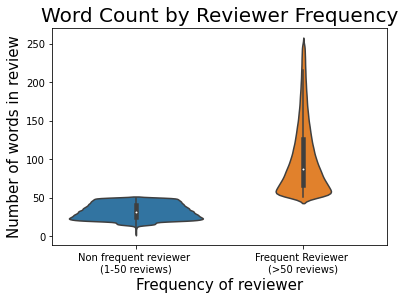

In [ ]:
sns.violinplot(x=data['freq'], y=data['Count'], )
plt.xlabel('Frequency of reviewer', fontsize=15)
plt.ylabel('Number of words in review', fontsize=15)
plt.title('Word Count by Reviewer Frequency', fontsize=20)
plt.show()

**Observation:**
* The distributions of word counts for frequent and infrequent reviews shows that infrequent reviewers have a large amount of reviews of low word count. 
* The largest concentration of word count is higher for frequent reviewers than for infrequent reviews.
* The median word count for frequent reviewers is higher than the median for infrequent reviewers.

##  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [ ]:
df['Text'] = df['Summary'] + ' ' + df['Text']
df = df.drop('Summary', axis=1)

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re
from tqdm import tqdm
from bs4 import BeautifulSoup

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])


preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(df['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 393931/393931 [02:29<00:00, 2639.93it/s]


In [ ]:
# combining required columns
df['clean_text'] = preprocessed_reviews
df = df[['Time','clean_text','Score']]
# reseting index
df = df.reset_index(drop=True)
# saving processed file
df = df.dropna(axis=0)
df.to_csv('preprocessed_data.csv',index=False)

## Featurization

In [1]:
!gdown --id 1HdxAq1EX_YKn7y1p2KOs_zm4uPHBBQ-Y

Downloading...
From: https://drive.google.com/uc?id=1HdxAq1EX_YKn7y1p2KOs_zm4uPHBBQ-Y
To: /content/preprocessed_data.csv
100% 115M/115M [00:02<00:00, 40.8MB/s]


In [50]:
df = pd.read_csv('preprocessed_data.csv')
df.dropna(inplace=True)
print(df.shape)
df.head()

(393930, 3)


,Time,clean_text,Score
0,1108425600,nice cadence catchy rhymes junei saw charming ...,4
1,1191456000,chicken soup rice months fun way children lear...,4
2,1194739200,love book miss hard cover version grew reading...,4
3,1210809600,classic get movie sound track sing along carol...,4
4,1212278400,chicken soup rice entertaining rhyming story c...,4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393930 entries, 0 to 393929
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Time        393930 non-null  datetime64[ns]
 1   clean_text  393930 non-null  object        
 2   Score       393930 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 9.0+ MB


In [51]:
def time_based_splitting(df, test_size=0.3):
    '''
    '''
    split_index = int((1-test_size)*df.shape[0])
    train_df = df[:split_index]
    test_df = df[split_index:]
    X_train = train_df['clean_text']
    X_test = test_df['clean_text']
    y_train = train_df['Score']
    y_test = test_df['Score']
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = time_based_splitting(df, test_size=0.3)
print(f'shape of X_train is {X_train.shape}')
print(f'shape of X_test is {X_test.shape}')
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train is (275751,)
shape of X_test is (118179,)
shape of y_train is (275751,)
shape of y_test is (118179,)


In [ ]:
pickle.dump(y_train, open('datasets/y_train', 'wb'))
pickle.dump(y_test, open('datasets/y_test', 'wb'))

### Bag of Words

In [ ]:
count_vect = CountVectorizer() 
count_vect.fit(X_train)

X_train_bow = count_vect.transform(X_train)
X_test_bow = count_vect.transform(X_test)
bow_features = count_vect.get_feature_names()

print("Shape of X_train_bow: ",X_train_bow.get_shape())
print("Shape of X_test_bow: ", X_test_bow.get_shape())
print("Number of Unique words: ", X_train_bow.get_shape()[1])

Shape of X_train_bow:  (275751, 104533)
Shape of X_test_bow:  (118179, 104533)
Number of Unique words:  104533


In [ ]:
pickle.dump(X_train_bow, open('datasets/X_train_bow', 'wb'))
pickle.dump(X_test_bow, open('datasets/X_test_bow', 'wb'))
pickle.dump(np.array(bow_features), open('datasets/bow_features','wb'))

### TF-IDF

In [ ]:
tf_idf_vect = TfidfVectorizer()
tf_idf_vect.fit(X_train)

X_train_tfidf = tf_idf_vect.transform(X_train)
X_test_tfidf = tf_idf_vect.transform(X_test)
tfidf_features = tf_idf_vect.get_feature_names()

print('Shape of X_train_tfidf', X_train_tfidf.get_shape())
print('Shape of X_test_tfidf', X_test_tfidf.get_shape())
print("Number of Unique words: ", X_train_bow.get_shape()[1])

Shape of X_train_tfidf (275751, 104533)
Shape of X_test_tfidf (118179, 104533)
Number of Unique words:  104533


In [ ]:
pickle.dump(X_train_tfidf, open('datasets/X_train_tfidf','wb'))
pickle.dump(X_test_tfidf, open('datasets/X_test_tfidf','wb'))
pickle.dump(tfidf_features, open('datasets/tfidf_features','wb'))

### Word2Vec

In [10]:
train_reviews = X_train.values
train_sentence = [review.split() for review in train_reviews]
# min_count = 5 considers only words that occured atleast 5 times
# size = length of vector
w2v_model = Word2Vec(train_sentence,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("Number of words that occured minimum 5 times: ",len(w2v_words))
print("Sample words: ", w2v_words[0:50])

Number of words that occured minimum 5 times:  30803
Sample words:  ['nice', 'catchy', 'rhymes', 'saw', 'charming', 'roses', 'chicken', 'soup', 'sprinkle', 'great', 'book', 'teach', 'children', 'months', 'year', 'repetition', 'phrases', 'funny', 'little', 'stories', 'accompanying', 'pictures', 'make', 'ideal', 'bedtime', 'read', 'not', 'nearly', 'good', 'sendak', 'books', 'like', 'wild', 'things', 'pierre', 'boy', 'care', 'still', 'carries', 'unique', 'brand', 'charm', 'rice', 'fun', 'way', 'learn', 'throughout', 'school', 'invent', 'poem']


In [ ]:
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))
pickle.dump(np.array(w2v_words),open("datasets/w2v_words","wb"))

[('terrific', 0.8484035134315491), ('fantastic', 0.842099130153656), ('excellent', 0.8390506505966187), ('good', 0.8386508226394653), ('awesome', 0.8150862455368042), ('wonderful', 0.781793475151062), ('perfect', 0.7554511427879333), ('fabulous', 0.7208791971206665), ('decent', 0.7109922170639038), ('nice', 0.7067837715148926)]
[('nastiest', 0.7930145263671875), ('disgusting', 0.7383906841278076), ('best', 0.7157711982727051), ('greatest', 0.7044209837913513), ('terrible', 0.6982998847961426), ('horrible', 0.6939760446548462), ('awful', 0.6887655854225159), ('horrid', 0.659850001335144), ('worse', 0.6480832099914551), ('nasty', 0.6271753907203674)]


### Average Word2Vec

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
def avg_word2vec(df):
    reviews_df = df.values
    sentences = [review.split() for review in reviews_df]
    sentence_vectors = [] # the avg-w2v for each sentence/review is stored in this list

    for sentence in tqdm(sentences): # for each review/sentence
        sentence_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sentence: # for each word in a review/sentence
            if word in w2v_words: 
                vec = w2v_model.wv[word]
                sentence_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sentence_vec /= cnt_words
        sentence_vectors.append(sentence_vec)
    print('Final vocab size:',len(sentence_vectors))
    print('Dimensionality of the word vectors:',len(sentence_vectors[0]))

    return sentence_vectors

print('Train Data')
X_train_avgw2v = avg_word2vec(X_train)
print('\nTest Data')
X_test_avgw2v = avg_word2vec(X_test)

Train Data


100%|██████████| 275751/275751 [21:02<00:00, 218.48it/s]


Final vocab size: 275751
Dimensionality of the word vectors: 50

Test Data


100%|██████████| 118179/118179 [09:00<00:00, 218.49it/s]


Final vocab size: 118179
Dimensionality of the word vectors: 50


In [ ]:
pickle.dump(np.array(X_train_avgw2v), open("datasets/X_train_avg_w2v","wb"))
pickle.dump(np.array(X_test_avgw2v), open("datasets/X_test_avg_w2v","wb"))

### TFIDF Word2Vec

In [8]:
model = TfidfVectorizer()
preprocessed_reviews = X_train.values
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feats = model.get_feature_names() # tfidf words/col-names
#pickle.dump(tfidf_feats, open("datasets/tfidf_feats_w2v","wb"))

In [53]:
def tfidf_word2vec(df):
    reviews_df = df.values
    sentences = [review.split() for review in reviews_df]
    common_words = set(w2v_words) & set(tfidf_feats)
    sentence_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    for sentence in tqdm(sentences): # for each review/sentence 
        sentence_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sentence: # for each word in a review/sentence
            if word in common_words:
                vec = w2v_model.wv[word]
                 #tf_idf = tf_idf_matrix[row, tfidf_feats.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence))
                sentence_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sentence_vec /= weight_sum
        sentence_vectors.append(sentence_vec)
    print('Final vocab size:',len(sentence_vectors))
    print('Dimensionality of the word vectors:',len(sentence_vectors[0]))

    return sentence_vectors

print('Train Data')
X_train_tfw2v = tfidf_word2vec(X_train)
print('\nTest Data')
X_test_tfw2v = tfidf_word2vec(X_test)

Train Data


100%|██████████| 275751/275751 [02:18<00:00, 1994.69it/s]


Final vocab size: 275751
Dimensionality of the word vectors: 50

Test Data


100%|██████████| 118179/118179 [01:03<00:00, 1875.01it/s]


Final vocab size: 118179
Dimensionality of the word vectors: 50


In [ ]:
pickle.dump(np.array(X_train_tfw2v), open("datasets/X_train_tf_w2v","wb"))
pickle.dump(np.array(X_test_tfw2v), open("datasets/X_test_tf_w2v","wb"))

### Loading saved vectors

In [62]:
# loading bow vectors
X_train_bow = pickle.load(open("datasets/X_train_bow","rb"))
X_test_bow = pickle.load(open("datasets/X_test_bow","rb"))
bow_features = pickle.load(open("datasets/bow_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_bow.shape))
print('shape of X_test_bow is {}'.format(X_test_bow.shape))


#loading tfidf vectors
X_train_tfidf = pickle.load(open("datasets/X_train_tfidf","rb"))
X_test_tfidf = pickle.load(open("datasets/X_test_tfidf","rb"))
tfidf_features = pickle.load(open("datasets/tfidf_features","rb"))
print('shape of X_train_tfidf is {}'.format(X_train_tfidf.shape))
print('shape of X_test_tfidf is {}'.format(X_test_tfidf.shape))


w2v_words = pickle.load(open("datasets/w2v_words","rb")).tolist()
#avgw2v
X_train_avgw2v = pickle.load(open("datasets/X_train_avg_w2v","rb"))
X_test_avgw2v = pickle.load(open("datasets/X_test_avg_w2v","rb"))
print('shape of X_train_avgw2v is {}'.format(X_train_avgw2v.shape))
print('shape of X_test_avgw2v is {}'.format(X_test_avgw2v.shape))


#tfidf-w2v
X_train_tfw2v = pickle.load(open("datasets/X_train_tf_w2v","rb"))
X_test_tfw2v = pickle.load(open("datasets/X_test_tf_w2v","rb"))
print('shape of X_train_tfw2v is {}'.format(X_train_tfw2v.shape))
print('shape of X_test_tfw2v is {}'.format(X_test_tfw2v.shape))


y_train = np.load('datasets/y_train',allow_pickle=True)
y_test = np.load('datasets/y_test',allow_pickle=True)
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train_bow is (275751, 104533)
shape of X_test_bow is (118179, 104533)
shape of X_train_tfidf is (275751, 104533)
shape of X_test_tfidf is (118179, 104533)
shape of X_train_avgw2v is (275751, 50)
shape of X_test_avgw2v is (118179, 50)
shape of X_train_tfw2v is (275751, 50)
shape of X_test_tfw2v is (118179, 50)
shape of y_train is (275751,)
shape of y_test is (118179,)
